# Qiskit: گیت‌های چندکیوبیتی

In [1]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex
from qiskit.quantum_info import random_statevector
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sim = Aer.get_backend('aer_simulator')
%matplotlib

Using matplotlib backend: agg


In [66]:
def get_statevector(qc: QuantumCircuit) -> np.ndarray:
    sim = Aer.get_backend('aer_simulator_statevector')
    qc.save_statevector()
    qobj = assemble(qc)
    state = sim.run(qobj).result().get_statevector(qc)
    return state

منطقا کیوبیت‌هایی که با هم کاری نداشته‌باشن نمی‌تونن خیلی محاسبات عجیبی انجام بدن، برای همینم می‌خوایم یه کاری کنیم کیوبیت‌هامون برهم‌کنش داشته‌باشن و سعی کنیم محاسباتی فراتر از محاسبات کلاسیک انجام بدیم.

## ۱. یادآوری: نشون‌دادن وضعیت‌های چندکیوبیتی

یادمون هست که وضعیت یه سیستم دو کیوبیتی رو می‌تونستیم با استفاده از ضرب تانسوری و به صورت زیر تعریف کنیم:

$$ |a\rangle = a_{00}|00\rangle + a_{01}|01\rangle + a_{10}|10\rangle + a_{11}|11\rangle = \begin{bmatrix} a_{00} \\ a_{01} \\ a_{10} \\ a_{11} \end{bmatrix} $$

که این‌جا $ a_{ij} $ ها اعداد مختلطی تحت این شرایط بودن:

$$ |a_{00}|^2 + |a_{01}|^2 + |a_{10}|^2 + |a_{11}|^2 = 1$$

و قوانین اندازه‌گیری هم مثل قبل بهشون اعمال می‌شد:
$$ p(|ij\rangle) = |\langle ij | a \rangle |^2 = |a_{ij}|^2 \space ; \space i, j \in \{0, 1\}$$

اگه ما دوتا کیوبیت جدا داشته‌باشیم، می‌تونیم بردار وضعیت‌شونو به این شکل توصیف کنیم:

$$ |a\rangle = \begin{bmatrix} a_0 \\ a_1 \end{bmatrix}, \quad |b\rangle = \begin{bmatrix} b_0 \\ b_1 \end{bmatrix} $$

$$ 
|ba\rangle = |b\rangle \otimes |a\rangle = \begin{bmatrix} b_0 \times \begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \\ b_1 \times \begin{bmatrix} a_0 \\ a_1 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} b_0 a_0 \\ b_0 a_1 \\ b_1 a_0 \\ b_1 a_1 \end{bmatrix}
$$

و اگه سه تا کیوبیت داشته‌باشیم:
$$ 
|cba\rangle = \begin{bmatrix} c_0 b_0 a_0 \\ c_0 b_0 a_1 \\ c_0 b_1 a_0 \\ c_0 b_1 a_1 \\
                              c_1 b_0 a_0 \\ c_1 b_0 a_1 \\ c_1 b_1 a_0 \\ c_1 b_1 a_1 \\
              \end{bmatrix}
$$

پس همون‌طور که می‌بینید اگه $n$تا کیوبیت داشته‌باشیم، برای دونستن وضعیتش باید $2^n$تا عدد مختلط رو نگه داریم. چون این اندازه به صورت نمایی افزایش پیدا می‌کنه، شبیه‌سازی رفتار کامپیوترهای کوانتومی روی کامپیوترهای کلاسیک سختن. مثلا یه لپ‌تاپ امروزی می‌تونه یه بردار وضعیت با حدود ۲۰ کیوبیت رو به راحتی شبیه‌سازی کنه، ولی شبیه‌سازی ۱۰۰  کیوبیت برای بزرگ‌ترین ابرکامیپوترها هم بیش از حد سخته.

برای یه دست‌گرمی ساده، سعی کنید وضعیت زیر رو به صورت ضرب تانسوری دوتا کیوبیت بنویسید.

$$|\psi\rangle = \frac{1}{\sqrt{2}}|00\rangle + \frac{i}{\sqrt{2}}|01\rangle $$

به عنوان یه مثال ساده، مدار زیر رو ببینید:

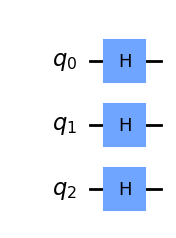

In [19]:
qc = QuantumCircuit(3)
# Apply H-gate to each qubit:
for qubit in range(3):
    qc.h(qubit)
# See the circuit:
qc.draw(output="mpl")

که وضعیت همه‌ی کیوبیت‌ها رو به استیت  $|+\rangle$ می‌بره، یعنی وضعیت نهایی‌مون به صورت زیر درمی‌آد:

$$ 
|{+++}\rangle = \frac{1}{\sqrt{8}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ 1 \\
                              1 \\ 1 \\ 1 \\ 1 \\
              \end{bmatrix}
$$

و نتیجه‌ش رو هم می‌تونیم با اجرای این کد تایید کنیم:

In [20]:
# Let's see the result
state = get_statevector(qc)
state_vertical = state.reshape(8, 1)
array_to_latex(state_vertical, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

## ۲. گیت‌های چندکیوبیتی

### ۱.۲ گیت‌های چندکیوبیتی ترکیبی

همون‌طور که یه سیستم $n$ کیوبیتی رو با یه بردار $2^n$ کیوبیتی نشون می‌دیم، برای اعمال تغییرات روشون به ماتریس‌هایی  با ابعاد $2^n \times 2^n $ نیاز داریم.
بعضی از این ماتریس‌ها رو می‌شه به صورت ضرب تانسوری دوتا گیت تک‌کیوبیتی نوشت. به عنوان مثال داریم:

$$
X|q_1\rangle \otimes H|q_0\rangle = (X\otimes H)|q_1 q_0\rangle
$$

که ماتریسش به این صورته

$$
X\otimes H = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \otimes \tfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} = \frac{1}{\sqrt{2}}
\begin{bmatrix} 0 \times \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
              & 1 \times \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
                \\ 
                1 \times \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
              & 0 \times \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}
\end{bmatrix} = \frac{1}{\sqrt{2}}
\begin{bmatrix} 0 & 0 & 1 & 1 \\
                0 & 0 & 1 & -1 \\
                1 & 1 & 0 & 0 \\
                1 & -1 & 0 & 0 \\
\end{bmatrix}
$$

این گیت‌ها رو می‌شه عملا به این صورت دید که داریم دوتا گیت تک‌کیوبیتی رو همزمان روی دوتا کیوبیت اجرا می‌کنیم.
توی Qiskit، ما می‌تونیم مداری که درست می‌کنیم رو به صورت یه ماتریس یکانی نشون بدیم. مثلا برای همین گیت $ (X\otimes H) $ داریم: 

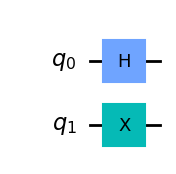

In [21]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.draw(output="mpl")

In [22]:
qc.save_unitary()
qobj = assemble(qc)
unitary = sim.run(qobj).result().get_unitary()

In [23]:
array_to_latex(unitary, prefix="\\text{Circuit = }\n")

<IPython.core.display.Latex object>

### ۲.۲. گیت CNOT

گیت CNOT یه گیت چندکیوبیتیه و گیت نسبتا خاصی‌ه، چراکه کاری که می‌کنه کاملا به این بستگی داره که وضعیت یکی از کیوبیت‌هامون در لحظه‌ی اجرا چی باشه، و به همین دلیل نمی‌شه به صورت ضرب تانسوری دوتا گیت تک‌کیوبیتی یکانی نوشتنش.

این گیت، یه گیت $X$ یا $NOT$ رو روی یکی از کیوبیت‌ها (که بهش می‌گیم ‍`target`) اعمال می‌کنه، تنها در صورتی که اون‌یکی کیوبیت (که بهش می‌گیم `control`) توی حالت $|1\rangle$ باشه. 

نمایش ماتریسی $CNOT$ ای که توش کیوبیت اول `control` ه و کیوبیت دومی `target` هم به این شکله:

$$
\text{CNOT} = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                              0 & 1 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
                              0 & 0 & 1 & 0 \\
              \end{bmatrix}
$$

و اگه کیوبیت اول `target` باشه و کیوبیت دومی `control`، $CNOT$ به این صورت در می‌آد.

$$
\text{CNOT} = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
                              0 & 0 & 1 & 0 \\
                              0 & 1 & 0 & 0 \\
              \end{bmatrix}
$$

به این معنا که $q_0$ کیوبیت `control` مون‌ه و $q_1$ کیوبیت `target`مون.

یه نحوه‌ی دیگه فکر کردن بهش اینه که $CNOT$ وقتی روی یه بردار ۴-بعدی (۲ کیوبیتی) اجرا بشه، جای ضریب‌های این دوتا وضعیت پایه رو با هم عوض می‌کنه:

$$ 
|a\rangle = \begin{bmatrix} a_{00} \\ a_{01} \\ a_{10} \\ a_{11} \end{bmatrix}, \quad \text{CNOT}|a\rangle = \begin{bmatrix} a_{00} \\ a_{01} \\ a_{11} \\ a_{10} \end{bmatrix} \begin{matrix} \\ \\ \leftarrow \\ \leftarrow \end{matrix}
$$

این گیت توی Qiskit به صورت `cx(control, target)` پیاده‌سازی شده.

### تمرین 💡

۱. می‌دونیم که گیت $CNOT$ روی دوتا کیوبیت control و target عمل می‌کنه. چک کنید و ببینید اگه کیوبیت controlمون توی superposition نباشه، می‌تونیم با CNOT کاری انجام بدیم که قبلا هم می‌تونستیم انجام بدیم یا نه.
و اون حالت رو با حالتی که کیوبیت `control` توی superpositionای از $ |0\rangle$ و $|1\rangle$ باشه مقایسه کنید. 

In [63]:
# ENTER CODE FOR Q1 HERE

## |00> + |01>
qc_1 = QuantumCircuit(2)
qc_1.h(1)
qc_1.cx(0, 1)

state_1 = get_statevector(qc_1)

# |00> + |01>
qc_2 = QuantumCircuit(2)
qc_2.h(1)
qc_2.i(1)

state_2 = get_statevector(qc_2)

print(f"Are these two the same thing? \n {np.all(state_1 == state_2)}")

# |10> + |11>
qc_3 = QuantumCircuit(2)
qc_3.h(1)
qc_3.x(0)
qc_3.cx(0, 1)

state_3 = get_statevector(qc_3)

# |10> + |11>
qc_4 = QuantumCircuit(2)
qc_4.h(1)
qc_4.x(0)
qc_4.i(1)

state_4 = get_statevector(qc_4)

print(f"Are these two also the same thing? \n {np.all(state_3 == state_4)}")

# |00> + |11>

qc_5 = QuantumCircuit(2)

qc_5.h(0)
qc_5.cx(0, 1)

state_5 = get_statevector(qc_5)

print(f"The entangled state: \n {state_5.reshape(4, 1)}")
print(f"Is it equal to the first case? \n {np.all(state_5 == state_1)}")
print(f"Is it equal to the second case? \n {np.all(state_5 == state_3)}")

Are these two the same thing? 
 True
Are these two also the same thing? 
 True
The entangled state: 
 [[0.70710678+0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.70710678+0.j]]
Is it equal to the first case? 
 False
Is it equal to the second case? 
 False


می‌بینیم که وقتی کیوبیت `control` مون توی وضعیت $ |0\rangle$ یا $|1\rangle$ باشه انگار داریم روی کیوبیت `target`مون عملیات $I$ انجام می‌دیم، ولی وقتی `control` توی superpositionای از $ |0\rangle$ و $|1\rangle$ باشه وضعیت کاملا فرق می‌کنه!

$$ \text{Isn't that something?!} $$


۲. توی جلسه‌ی دست به کار روز اول، با چهار بردار متعامد یکه آشنا شدیم که یه پایه‌ی برای فضای برداری‌مون تشکیل 
می‌دادن. به این بردارها که این زیر می‌بینیم‌شون Bell State می‌گن.

$$|{\Phi_\pm}\rangle = \frac{1}{\sqrt 2}\big(|0\rangle| 0\rangle\pm |1\rangle| 1\rangle\big), \qquad |{\Psi_{\pm}}\rangle=\frac{1}{\sqrt 2}\big(|0\rangle| 1\rangle\pm  |1\rangle|0\rangle\big).$$

با کمک گیت‌هایی که تا الان بهتون معرفی شده، یکی از Bell Stateها رو بسازید و ببینید با استفاده از گیت‌های تک‌کیوبیتی چه‌طور می‌تونید بردارهای این پایه رو به هم تبدیل کنید.


In [77]:
# ENTER CODE FOR Q2 HERE

qcs = [QuantumCircuit(2) for _ in range(4)]
x_qc, z_qc = (QuantumCircuit(2) for _ in range(2))

qcs[0].h(0)
qcs[0].cx(0, 1)

x_qc.x(1)
z_qc.z(1)

qcs[1] = qcs[0] + x_qc
qcs[2] = qcs[0] + z_qc
qcs[3] = qcs[1] + z_qc

bells = [get_statevector(qc) for qc in qcs]

array_to_latex(bells, prefix="\\text{The 4 bell states augmented in one matrix = }\n")

<IPython.core.display.Latex object>


۳. یه گیت معروف دیگه، گیت $SWAP$ هست که همون‌طور که از اسمش مشخصه، دوتا کیوبیت رو می‌گیره و اون‌ها رو با هم جابه‌جا می‌کنه، یعنی بردار کیوبیت ۱ رو تبدیل به بردار کیوبیت ۲ می‌کنه و بالعکس. نمایش ماتریسی این گیت رو این زیر می‌بینید:

$$
\text{SWAP} = \begin{bmatrix} 
                                1 & 0 & 0 & 0 \\
                              0 & 0 & 1 & 0 \\
                              0 & 1 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
              \end{bmatrix}
$$
سعی کنید این گیت رو با استفاده از گیت‌هایی که تا حالا بهتون معرفی شده بسازید.

In [117]:
# ENTER CODE FOR Q3 HERE

init_state = random_statevector(4).data
print(f"The initial state is: \n {init_state}")

qc_swap = QuantumCircuit(2)
qc_swap.initialize(init_state)

qc_swap.swap(0, 1)

swap_state = get_statevector(qc_swap)

print(f"The swapped state is: \n {swap_state}")

qc_triple_cnot = QuantumCircuit(2)
qc_triple_cnot.initialize(init_state)
qc_triple_cnot.cx(0, 1)
qc_triple_cnot.cx(1, 0)
qc_triple_cnot.cx(0, 1)

cnot_x3_state = get_statevector(qc_triple_cnot)

print(f"Is doing 3 CNOTs equal to a SWAP? {np.all(cnot_x3_state == swap_state)}")

The initial state is: 
 [-0.14120413+0.17954327j  0.47721124-0.64422677j  0.04474872-0.15465144j
 -0.52808328+0.01659646j]
The swapped state is: 
 [-0.14120413+0.17954327j  0.04474872-0.15465144j  0.47721124-0.64422677j
 -0.52808328+0.01659646j]
Is doing 3 CNOTs equal to a SWAP? True



$CNOT_{(0, 1)}CNOT_{(1, 0)}CNOT_{(0, 1)} = \begin{bmatrix}               1 & 0 & 0 & 0 \\
                              0 & 1 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
                              0 & 0 & 1 & 0 \\
\end{bmatrix} 
\begin{bmatrix}               1 & 0 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
                              0 & 0 & 1 & 0 \\
                              0 & 1 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}               1 & 0 & 0 & 0 \\
                              0 & 1 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
                              0 & 0 & 1 & 0 \\
\end{bmatrix}
= 
\begin{bmatrix} 
                              1 & 0 & 0 & 0 \\
                              0 & 0 & 1 & 0 \\
                              0 & 1 & 0 & 0 \\
                              0 & 0 & 0 & 1 \\
\end{bmatrix}
= SWAP $

$$ |\psi \rangle = \big(a |0\rangle + b |1\rangle \big) \big( c |0\rangle + d |1\rangle \big) =
ac |00\rangle + ad |01\rangle + bc |10\rangle + bd |11\rangle \\
CNOT_{(0, 1)} |\psi \rangle = ac |00\rangle + ad |01\rangle + bc |11\rangle + bd |10\rangle \\
CNOT_{(1, 0)}\big( CNOT_{(0, 1)} |\psi \rangle \big) =  ac |00\rangle + ad |11\rangle + bc |01\rangle + bd |10\rangle \\
CNOT_{(0, 1)} \left( CNOT_{(1, 0)} \big( CNOT_{(0, 1)} |\psi \rangle \big) \right) = ac |00\rangle + ad |10\rangle + bc |01\rangle + bd |11\rangle
= \big( c |0\rangle + d |1\rangle \big) \big(a |0\rangle + b |1\rangle \big)$$


۴. بعضی کامپیوترهای کوانتومی به خاطر محدودیت‌های سخت‌افزاری که دارن، فقط می‌تونن CNOT رو در یه جهت اعمال کنن، یعنی فقط می‌تونن `cx(0, 1)` رو انجام بدن. آیا می‌شه کاری کرد که بدون استفاده‌ی مستقیم از `cx(1, 0)‍‍` این کارکرد رو پیاده‌سازی کرد؟ اگه آره، چطور؟ اگه نه، چرا؟

In [129]:
# ENTER CODE FOR Q4 HERE

init_state = random_statevector(4).data
print(f"The initial state is: \n {init_state}")

qc_10 = QuantumCircuit(2)
qc_10.initialize(init_state)

qc_10.cx(1, 0)

state_10 = get_statevector(qc_10)

qc_01 = QuantumCircuit(2)
qc_01.initialize(init_state)

qc_01.h([0, 1])
qc_01.cx(0, 1)
qc_01.h([0, 1])

state_01 = get_statevector(qc_01)

# Error is in the range of 1e-16, so python won't see them as equals by default. 
print(f"Are the two circuits equal? \n {np.allclose(state_10, state_01)})

[ 0.31121196-0.14756099j  0.5715482 -0.37516327j -0.48473565+0.08999709j
  0.2776306 +0.30628608j]
[ 0.31121196-0.14756099j  0.5715482 -0.37516327j -0.48473565+0.08999709j
  0.2776306 +0.30628608j]
True


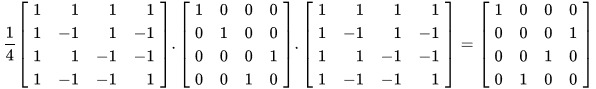

### ۳.۲. !Controlled Everything

توی قسمت قبل با گیت $U_3$ آشنا شدید که کلی‌ترین حالت یه ماتریس یکانی بود که می‌تونستیم روی کیوبیت‌مون اعمال کنیم.

حالا، توجه داشته‌باشید که ما این کنترلی که روی $CNOT$مون انجام دادیم رو می‌تونیم روی همه‌ی کیوبیت‌ها انجام بدیم.
به این معنا که، اگه کیوبیت `control`مون $|0\rangle$ باشه، ماتریس $I$ به کیوبیت `target` اعمال می‌شه و اگه $|1\rangle$ باشه، ماتریس $U_3$ به کیوبیت `target` اعمال می‌شه. به این عمل‌گر می‌گیم Controlled-U که شکل‌ش رو به صورت دقیق این زیر می‌بینید.

$$
\newcommand{\th}{\frac{\theta}{2}}
CU(\theta, \phi, \lambda, \gamma)\ q_{control}, q_{target} =
                |0\rangle\langle 0| \otimes I +
                e^{i\gamma}|1\rangle\langle 1| \otimes U(\theta,\phi,\lambda) =
                \begin{pmatrix}
                    1 & 0 & 0                             & 0 \\
                    0 & 1 & 0                             & 0 \\
                    0 & 0 & e^{i\gamma} \cos(\th)         & -e^{i(\gamma + \lambda)}\sin(\th) \\
                    0 & 0 & e^{i(\gamma + \phi)}\sin(\th) & e^{i(\gamma + \phi+\lambda)}\cos(\th)
                \end{pmatrix}
$$

[اگه دقت کنید، می‌بینید که این عمل‌گر از Augment کردن قطری دوتا ماتریس یکانی ساخته شده که ماتریس یکانی اول همون $I$ه و ماتریس یکانی دوم همون $U_3$ و طبق همین قاعده، $CNOT$ هم دقیقا همین ساختار رو داشت.]

این عمل‌گر توی Qiskit به این صورت پیاده‌سازی شده: `cu(theta, phi, lam, gamma, control_qubit, target_qubit`

**نکته:** می‌تونید یه لیست کامل از عمل‌گرهایی که می‌تونید توی یه `QuantumCircuit` اجرا کنید رو از [این‌جای](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html) مستندات Qiskit ببینید. (برای سوال‌های بعدی لازم‌تون می‌شه. :)) )

## تمرین‌های سخت!  🧠

حالا، یه سری بردار وجود دارن که درست کردنشون به همین سادگی‌ها هم نیست، ولی می‌شه از بردار $|0\rangle^{\otimes n} $ شروع کرد و با استفاده از گیت‌هایی که تا الان شناختیم، ساخت‌شون.

خیلی نگران نباشید، با هم‌فکری و یه مقدار بازی‌کردن با جبرخطی‌ش، می‌تونید راحت استیت‌ها رو بسازید.

برای همه‌ی سوال‌های این قسمت، یه تابع بنویسید که ورودی‌ای که تو سوال اومده رو بگیره و خروجی‌ای که اومده رو ریترن کنه. (خروجی می‌تونه به صورت یه آبجکت `QuantumCircuit` باشه.)

### ۱. استیت GHZ.

ورودی:
$$ n \in \mathbb{N} \space ; n \geq 1 $$

خروجی:

$$\frac{1}{\sqrt{2}} \big (|0\dots0\rangle + |1\dots1\rangle\big) = \frac{1}{\sqrt{2}} \big (|0\rangle^{\otimes n} + |1\rangle^{\otimes n}\big)$$

In [3]:
# ENTER CODE FOR Q1 HERE
def ghz_circuit(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(1, n):
        qc.cx(i-1, i)
    
    return qc

In [9]:
n = 4
ghz = ghz_circuit(n)
state = get_statevector(ghz)
array_to_latex(state.reshape(2**n, 1), prefix="\\text{GHZ = }\n")

<IPython.core.display.Latex object>

### ۲. سوپرپوزیشن بین bitstring و $|0\rangle^{\otimes n}$

ورودی: 

$$ s \in \{0, 1\}^{\otimes n} ; \space e.g \space (for \space n=2): 10 $$

خروجی:

$$ \frac{1}{\sqrt{2}}\big(|00\rangle + |10\rangle\big) $$

In [17]:
def zero_bit_superposition(bits: str) -> QuantumCircuit:
    # Because qiskit uses little-endian encoding
    bits = bits[::-1]
    length = len(bits)
    qc = QuantumCircuit(length)
    first_1 = bits.find('1')
    qc.h(first_1)
    for i in range(first_1 + 1, length):
        if bits[i] == '1':
            qc.cx(first_1, i)
    
    return qc

In [18]:
bits = '10'
zero_sup = zero_bit_superposition(bits)
state = get_statevector(zero_sup)
length = 2**len(bits)
array_to_latex(state.reshape(length, 1), prefix="\\text{Superposition = }\n", max_size=length)

<IPython.core.display.Latex object>

### ۳. سوپرپوزیشن بین دوتا bitstring

ورودی: 

$$ s_1, s_2 \in \{0, 1\}^{\otimes n} \space ; \space e.g \space (for \space n=2): \space 10, \space 01$$

خروجی:

$$ \frac{1}{\sqrt{2}}\big(|01\rangle + |10\rangle\big) $$

In [38]:
def bit_bit_superposition(bits1: str, bits2: str) -> QuantumCircuit:
    # Again, because of qiskit using little-endian 
    bits1, bits2 = bits1[::-1], bits2[::-1]
    length = len(bits1)
    qc = QuantumCircuit(length)
    diffs = [i for i in range(length) if bits1[i] != bits2[i]]
    first, rest = diffs[0], diffs[1:]
    qc.h(first)
    for i in rest:
        if bits1[first] == '1':
            qc.cx(first, i)
            if bits1[i] == '0':
                qc.x(i)
    return qc

In [40]:
bits1, bits2 = '1001', '0110'
sup = bit_bit_superposition(bits1, bits2)
state = get_statevector(sup)
length = 2**len(bits1)
pr_str = f"|{bits1}> and |{bits2}>"
array_to_latex(state.reshape(length, 1), prefix=f"\\text{{Superposition of {pr_str} = }}\n", max_size=length)

<IPython.core.display.Latex object>

### ۴. این استیت:
$$\frac{1}{\sqrt{3}} \big(|00\rangle + |01\rangle + |10\rangle\big)$$

In [76]:
# Qiskit is too lazy to implement a simulation of the cry gate, so we use the decomposition in:
# https://qiskit.org/textbook/ch-gates/more-circuit-identities.html

def c_ry(qc: QuantumCircuit, theta: float, c, t) -> QuantumCircuit:
    qc.ry(theta/2, t)
    qc.cx(c,t)
    qc.ry(-theta/2, t)
    qc.cx(c,t)
    return qc

In [72]:
def three_two():
    from numpy import arcsin, sqrt, pi
    
    qc = QuantumCircuit(2)
    alpha = 2 * arcsin(1/sqrt(3))
    beta = pi / 2
    qc.ry(alpha, 1)
    
    #Controlled on 0
    qc.x(1)
    qc = c_ry(qc, beta, 1, 0)
    qc.x(1)
    
    return qc

In [74]:
three_2 = three_two()
state = get_statevector(three_2)
array_to_latex(state.reshape(2**2, 1), prefix="\\text{three_two = }\n")

<IPython.core.display.Latex object>

### ۵. استیت هاردی:
$$\frac{1}{\sqrt{12}} \big(3|00\rangle + |01\rangle + |10\rangle + |11\rangle\big)$$

In [84]:
def hardy_state():
    from numpy import sqrt, arctan, arccos, cos
    
    qc = QuantumCircuit(2)
    
    num = 3 / sqrt(12)
    t1 = 2 * arctan(1/3)
    t2 = 2 * arccos(num / cos(t1 / 2))
    t3 = 2 * arctan(1/2)
    
    qc.ry(t1, 0)
    qc.ry(t2, 1)
    qc = c_ry(qc, t3, 1, 0)

    return qc

In [85]:
hardy = hardy_state()
state = get_statevector(hardy)
array_to_latex(state.reshape(2**2, 1), prefix="\\text{Hardy State = }\n")

<IPython.core.display.Latex object>